In [1]:
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cmocean
import cosima_cookbook as cc
import dask.distributed as dsk
import glob
import matplotlib.gridspec as gs
import matplotlib.path as mpath
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import numpy as np
import scipy.stats as st
import xarray as xr
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
from palettable.colorbrewer.diverging import RdBu_11_r as rdbu_cm
from joblib import Parallel, delayed

import warnings # ignore these warnings
warnings.filterwarnings("ignore", category = FutureWarning)
warnings.filterwarnings("ignore", category = UserWarning)
warnings.filterwarnings("ignore", category = RuntimeWarning)

import cmocean.cm as cmocean
from mpl_toolkits.axes_grid1 import make_axes_locatable
#figdir = '/home/561/jn8053/g_e14/figures-tmp/'

from PIL import Image
import glob

clnt = dsk.Client()
clnt

/g/data/hh5/public/apps/miniconda3/envs/analysis3-21.07/lib/python3.9/contextlib.py:126: UserWarning: Creating scratch directories is taking a surprisingly long time. This is often due to running workers on a network file system. Consider specifying a local-directory to point workers to write scratch data to a local disk.
  next(self.gen)
/g/data/hh5/public/apps/miniconda3/envs/analysis3-21.07/lib/python3.9/contextlib.py:126: UserWarning: Creating scratch directories is taking a surprisingly long time. This is often due to running workers on a network file system. Consider specifying a local-directory to point workers to write scratch data to a local disk.
  next(self.gen)
/g/data/hh5/public/apps/miniconda3/envs/analysis3-21.07/lib/python3.9/contextlib.py:126: UserWarning: Creating scratch directories is taking a surprisingly long time. This is often due to running workers on a network file system. Consider specifying a local-directory to point workers to write scratch data to a local 

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /proxy/8787/status,
Dashboard: /proxy/8787/status,Workers: 4
Total threads: 4,Total memory: 100.00 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:46825,Workers: 4
Dashboard: /proxy/8787/status,Total threads: 4
Started: Just now,Total memory: 100.00 GiB
Comm: tcp://10.6.122.40:36269,Total threads: 1
Dashboard: /proxy/45333/status,Memory: 25.00 GiB
Nanny: tcp://127.0.0.1:33457,


In [2]:
# Font size
plt.rcParams['font.size'] = 16
# Axes
plt.rcParams['axes.facecolor'] = 'white'
plt.rcParams['xtick.labelsize'] = 16
plt.rcParams['ytick.labelsize'] = 16
# Saving parameters
plt.rcParams['savefig.dpi'] = 100
plt.rcParams['savefig.bbox'] = 'tight'

In [3]:
def figure_along_slope():
    fig = plt.figure(figsize = (15, 10))
    gd = gs.GridSpec(2, 2, figure = fig, width_ratios = [1, .03])
    axs = [fig.add_subplot(gd[0,0]),fig.add_subplot(gd[1,0]), fig.add_subplot(gd[:,1])]
    for ax in axs[:-1]:
        ax.set_xlim(-270, -250);
        ax.set_ylim(-67, -60);
        ax.set_xticks(np.arange(-270,-250 ,5))
        ax.set_yticks(np.arange(-67, -60, 2))
    axs[0].set_title('IAF SST')
    
    return fig, axs

In [4]:
db='/g/data/x77/amh157/PanAnt/panant.db'
session=cc.database.create_session(db)

OperationalError: (sqlite3.OperationalError) unable to open database file
(Background on this error at: http://sqlalche.me/e/13/e3q8)

In [4]:
#session = cc.database.create_session()

In [5]:
# database for control simulation
master_session = cc.database.create_session('/g/data/ik11/databases/cosima_master.db')

In [6]:
from cosima_cookbook import explore
dbx = explore.DatabaseExplorer #(session=session)
dbx

cosima_cookbook.explore.DatabaseExplorer

In [7]:
ee = explore.ExperimentExplorer(session=master_session, experiment='01deg_jra55v13_ryf9091')
ee

ExperimentExplorer(children=(HTML(value='\n            <h3>Experiment Explorer</h3>\n\n            <p>Select a…

In [8]:
mask_file = np.load('/g/data/e14/hd4873/runs/parcels/input/proj01/Antarctic_slope_contour_ht_1000m.npz')
shelf_mask = mask_file['contour_masked_above']
xt_ocean = mask_file['xt_ocean']
yt_ocean = mask_file['yt_ocean']
shelf_mask[shelf_mask != 0] = np.nan
shelf_mask[shelf_mask == 0] = 1
shelf_mask = xr.DataArray(shelf_mask, dims = ['yt_ocean', 'xt_ocean'], coords = {'yt_ocean':yt_ocean, 'xt_ocean':xt_ocean})

In [9]:
ht = cc.querying.getvar('01deg_jra55v140_iaf_cycle3', 'ht', master_session, n = 1)

In [27]:
# topography data for plotting:
land_mask = np.squeeze(ht.values)*0
land_mask[np.isnan(land_mask)] = 1
land_mask = np.where(land_mask==1,land_mask,np.nan)
land_mask_masked = np.ma.masked_where((land_mask==0),land_mask)
# make land go all the way to -90S:
land_mask_lat = ht.yt_ocean.values
land_mask_lat[0] = -90

fontsize=13

In [65]:
expt='01deg_jra55v140_iaf_cycle3'
start = '2000-01-01 00:00:00'
end = '2018-12-31 00:00:00'
#'2150-12-31 00:00:00'

temp = cc.querying.getvar(expt='01deg_jra55v140_iaf_cycle3', variable='temp', 
                          session=master_session, frequency='1 daily',
                          start_time=start, 
                          end_time=end).sel(yt_ocean=slice(-70,-60)).sel(xt_ocean=slice(-270,-250)).sel(time = slice(start,end))

In [66]:
temp

,Array,Chunk
Bytes,88.02 GiB,1.17 MiB
Shape,"(6939, 75, 227, 200)","(1, 19, 135, 120)"
Count,24314309 Tasks,166536 Chunks
Type,float32,numpy.ndarray


In [67]:
# select out bottom values:
depth_array = temp[0] * 0 + temp.st_ocean
max_depth = depth_array.max(dim = 'st_ocean', skipna= True)

bottom_temp = temp.where(depth_array.st_ocean >= max_depth)
bottom_temp = bottom_temp.sum(dim = 'st_ocean')
bottom_temp = bottom_temp.load()

/g/data/hh5/public/apps/miniconda3/envs/analysis3-21.07/lib/python3.9/site-packages/dask/utils.py:35: RuntimeWarning: All-NaN slice encountered
  return func(*args, **kwargs)
/g/data/hh5/public/apps/miniconda3/envs/analysis3-21.07/lib/python3.9/site-packages/distributed/worker.py:3808: RuntimeWarning: All-NaN slice encountered
  return func(*map(execute_task, args))


In [53]:
str(bottom_temp.time['time.month'].values)

'[ 1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1\n  1  1  1  1  1  1  1  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2\n  2  2  2  2  2  2  2  2  2  2  2  3  3  3  3  3  3  3  3  3  3  3  3  3\n  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  4  4  4  4  4  4\n  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4\n  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5\n  5  5  5  5  5  5  5  6  6  6  6  6  6  6  6  6  6  6  6  6  6  6  6  6\n  6  6  6  6  6  6  6  6  6  6  6  6  6  7  7  7  7  7  7  7  7  7  7  7\n  7  7  7  7  7  7  7  7  7  7  7  7  7  7  7  7  7  7  7  7  8  8  8  8\n  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8\n  8  8  8  9  9  9  9  9  9  9  9  9  9  9  9  9  9  9  9  9  9  9  9  9\n  9  9  9  9  9  9  9  9  9 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10\n 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 11 11 11 11 11 11 11 11\n 11 11 11 11 11 11 11 11 11 11 11 11 

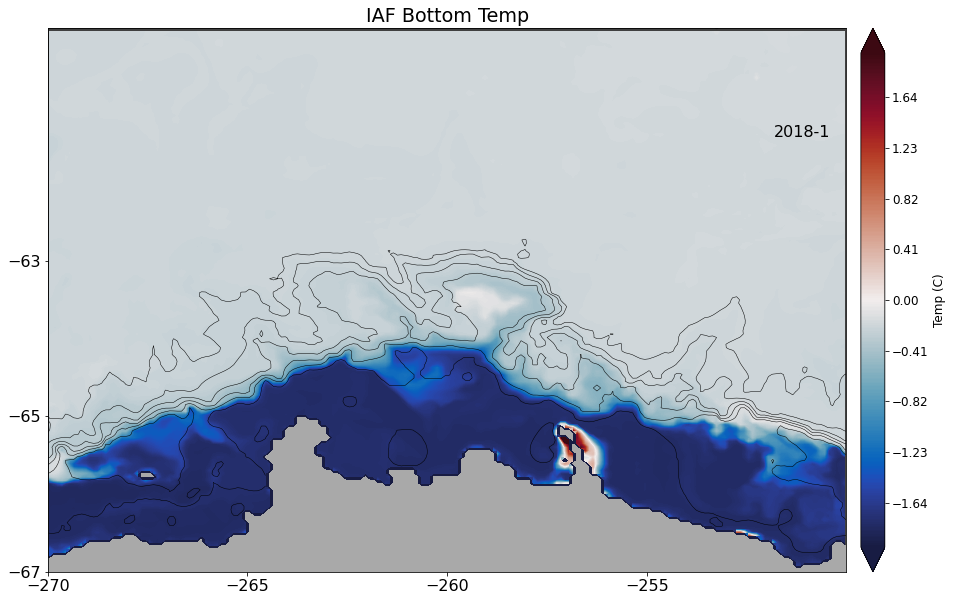

In [62]:
    #fig, axs = figure_along_slope()
    fontsize=12
    plt.figure(figsize=(15,10))
    plt.subplot(1,1,1)
    plt.gca().patch.set_color('.25')
#    gd = gs.GridSpec(2, 2, figure = fig, width_ratios = [1, .03])
#    axs = fig.add_subplot(gd[0,0])
    plt.xlim(-270, -250);
    plt.ylim(-67, -60);
    plt.xticks(np.arange(-270,-250 ,5))
    plt.yticks(np.arange(-67, -62, 2))
    plt.title('IAF Bottom Temp')
    ax = plt.gca()
        
    plt.text(0.98, 0.8, str(bottom_temp.isel(time = 0)['time.year'].values)+'-'+str(bottom_temp.isel(time = 0)['time.month'].values), 
                horizontalalignment = 'right', transform = ax.transAxes);
    psi = plt.contourf(bottom_temp.xt_ocean,bottom_temp.yt_ocean, bottom_temp.isel(time = 0)-273.13, 
                          levels = np.arange(-2, 2.01, .01), cmap=cmocean.balance, extend = 'both') #cmap=cmocean.balance cmap = plt.cm.cool
    plt.contour(ht.xt_ocean, ht.yt_ocean, ht, levels = [500,1000,1500,2000,2500,3000], colors = 'k', linewidths = 0.5)
    plt.contourf(ht.xt_ocean, land_mask_lat,land_mask_masked,colors='darkgrey',zorder=2)
    
    # colorbar:
    ax = plt.gca()
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="3%", pad=0.2)
    cbar = plt.colorbar(psi, cax=cax,orientation = 'vertical')
    cbar.set_label(r'Temp (C)',fontsize=fontsize,labelpad=5)
    cbar.ax.tick_params(labelsize=fontsize)


In [71]:
#temp levels = np.arange(-2, 4.02, .02)
#salt levels = np.arange(33, 35, .0)

def figures_bottemp(i):
    #fig, axs = figure_along_slope()
    fontsize=12
    plt.figure(figsize=(15,10))
    plt.subplot(1,1,1)
    plt.gca().patch.set_color('.25')
#    gd = gs.GridSpec(2, 2, figure = fig, width_ratios = [1, .03])
#    axs = fig.add_subplot(gd[0,0])
    plt.xlim(-270, -250);
    plt.ylim(-67, -60);
    plt.xticks(np.arange(-270,-250 ,5))
    plt.yticks(np.arange(-67, -60, 2))
    plt.title('IAF Bottom Temp')
    ax = plt.gca()
        
    plt.text(0.98, 0.8, str(bottom_temp.isel(time = i)['time.year'].values)+'-'+str(bottom_temp.isel(time = i)['time.month'].values), 
                horizontalalignment = 'right', transform = ax.transAxes);
    psi = plt.contourf(bottom_temp.xt_ocean,bottom_temp.yt_ocean, bottom_temp.isel(time = i)-273.13, 
                          levels = np.arange(-2, 2.02, .01), cmap=cmocean.balance, extend = 'both')
    plt.contour(ht.xt_ocean, ht.yt_ocean, ht, levels = [500,1000,1500,2000,2500,3000], colors = 'k', linewidths = 0.5)
    plt.contourf(ht.xt_ocean, land_mask_lat,land_mask_masked,colors='darkgrey',zorder=2)

    # colorbar:
    ax = plt.gca()
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="3%", pad=0.2)
    cbar = plt.colorbar(psi, cax=cax,orientation = 'vertical')
    cbar.set_label(r'Temp (C)',fontsize=fontsize,labelpad=5)
    cbar.ax.tick_params(labelsize=fontsize)
    #plt.colorbar(psi, cax = ax, orientation = 'vertical', shrink = .5).set_label('SST [$^{\circ}$C]')
    plt.savefig('/home/561/pas561/gdv45/jnb/Denman/movies/bottomT-'+str(i).zfill(4)+'.png', facecolor = 'white', bbox_inches = 'tight')
    plt.close()

In [69]:
len(bottom_temp.time)

6939

In [72]:
Parallel(n_jobs = -1)(delayed(figures_bottemp)(n) for n in range(len(bottom_temp.time)));

In [73]:
# Create the frames
frames = []
imgs = sorted(glob.glob('/home/561/pas561/gdv45/jnb/Denman/movies/bottomT-*.png'))

for i in imgs:
    new_frame = Image.open(i)
    frames.append(new_frame)

# Save into a GIF file that loops forever
frames[0].save('/home/561/pas561/gdv45/jnb/Denman/movies/botT01cyc3_2010to2018.gif', format='GIF',
               append_images=frames[1:],
               save_all=True,
               duration=60, loop=0)

In [74]:
#use command line to convert png files to mp4
#http://trac.ffmpeg.org/wiki/Slideshow
#ffmpeg -i bottomT-%04d.png botT01cyc3_2010to2018.mp4
#ffmpeg -pattern_type glob -i '*.png' botT01cyc3_2010to2018_part2.mp4

NameError: name 'ffmpeg' is not defined

array([-2.00000000e+00, -1.98000000e+00, -1.96000000e+00, -1.94000000e+00,
       -1.92000000e+00, -1.90000000e+00, -1.88000000e+00, -1.86000000e+00,
       -1.84000000e+00, -1.82000000e+00, -1.80000000e+00, -1.78000000e+00,
       -1.76000000e+00, -1.74000000e+00, -1.72000000e+00, -1.70000000e+00,
       -1.68000000e+00, -1.66000000e+00, -1.64000000e+00, -1.62000000e+00,
       -1.60000000e+00, -1.58000000e+00, -1.56000000e+00, -1.54000000e+00,
       -1.52000000e+00, -1.50000000e+00, -1.48000000e+00, -1.46000000e+00,
       -1.44000000e+00, -1.42000000e+00, -1.40000000e+00, -1.38000000e+00,
       -1.36000000e+00, -1.34000000e+00, -1.32000000e+00, -1.30000000e+00,
       -1.28000000e+00, -1.26000000e+00, -1.24000000e+00, -1.22000000e+00,
       -1.20000000e+00, -1.18000000e+00, -1.16000000e+00, -1.14000000e+00,
       -1.12000000e+00, -1.10000000e+00, -1.08000000e+00, -1.06000000e+00,
       -1.04000000e+00, -1.02000000e+00, -1.00000000e+00, -9.80000000e-01,
       -9.60000000e-01, -